# Import Dataset from Kaggle

In [92]:
import os
from dotenv import load_dotenv

# Load environment variables from a file .env
load_dotenv()  # Be sure to set the .env file beforehand

# Get the path to the Kaggle API configuration directory from the .env file
kaggle_config_dir = os.getenv("KAGGLE_CONFIG_DIR")

if kaggle_config_dir:
    # Setting the environment variable for the Kaggle API configuration directory
    os.environ['KAGGLE_CONFIG_DIR'] = kaggle_config_dir
    print(f'Path to Kaggle API configuration directory: {kaggle_config_dir}')
else:
    raise ValueError("The KAGGLE_CONFIG_DIR variable is not set in the .env file")

def download_kaggle_dataset(dataset, download_path='.'):
    try:
        import kaggle
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(dataset, path=download_path, unzip=True)
        print(f'Dataset {dataset} has been successfully downloaded and saved in: {download_path}')
    except Exception as e:
        print(f'Error while downloading: {e}')

# Function to check if the dataset has already been downloaded
def is_dataset_downloaded(download_path):
    if os.path.exists(download_path) and len(os.listdir(download_path)) > 0:
        print("Dataset is already downloaded.")
        return True
    else:
        print("Dataset is not downloaded. Proceeding to download.")
        return False

# Definition of the dataset and download path
data_set = 'ronanpickell/b200c-lego-classification-dataset'
download_path = 'data/lego-dataset'  # Path must comply with Linux/WSL

# Download dataset if not already downloaded
if not is_dataset_downloaded(download_path):
    api.dataset_download_files(dataset, path=download_path, unzip=True)
    print("Dataset downloaded successfully.")


Path to Kaggle API configuration directory: /mnt/e/_DataScience/InfoShareAcademy/60_GitHub/jdszr15-RocketScience/Projekt DL/.kaggle
Dataset is already downloaded.


# Preperations

In [93]:
import os
import pickle
import random
import warnings
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image as Image_PIL
from IPython.display import Image, display

os.environ["KERAS_BACKEND"] = "tensorflow"

# Ignore warnings
warnings.filterwarnings("ignore")

In [94]:
# Check GPU Configuration
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Helper funtions

In [95]:
def list_paths(folder):
    """
    Generates a list of paths to all files in a given folder.

    This function traverses the specified folder and all its subfolders,
    then creates a list of full paths to the files found therein.

    Args:
        folder (str): The path to the folder that needs to be searched.

    Returns:
        list: A list of full paths to the files located in the given folder and its subfolders.
    """
    paths = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            paths.append(os.path.join(root, file))
    
    return paths


In [96]:
def take_sample(path, percent):
    """
    Takes a random sample of paths based on a given percentage.

    Args:
        path (list): The list of file paths.
        percent (int): The percentage of files to be selected.

    Returns:
        list: A list containing the randomly selected paths.
    """
    if percent < 0 or percent > 100:
        raise ValueError("The percentage must be in the range of 0 to 100")
    
    liczba_elementow = int(len(path) * (percent / 100))
    wybrane_elementy = random.sample(path, liczba_elementow)
    
    return wybrane_elementy


In [97]:
def set_num_of_categories(folder, num_classes, folder_deep=0):
    """
    Returns a list of the first num_classes directories at a given depth.

    Args:
        folder (str): The root folder to start the search from.
        num_classes (int): The number of directories to return.
        folder_deep (int): The depth of subfolders to be considered.

    Returns:
        list: A list of directory names.
    """
    dir_list = []
    for i, (root, dirs, files) in enumerate(os.walk(folder)):
        if i == folder_deep:
            for j, dir in enumerate(dirs):
                dir_list.append(os.path.join(root, dir))
                if j >= (num_classes - 1):
                    break
        else:
            continue
    
    return dir_list

In [98]:
def process_data(folder, percent, take_sample_of, num_classes=None, folder_deep=0):
    """
    Processes data by either taking a sample from the dataset or restricting to a certain number of classes.

    Args:
        folder (str): The path to the main folder containing the data.
        percent (int): The percentage of files to be selected.
        take_sample_of (str): The criteria to take sample from ('dataset' or 'classes').
        num_classes (int, optional): The number of classes to be considered if take_sample_of is 'classes'. Default is None.
        folder_deep (int, optional): The depth to which classes are considered. Default is 0.

    Returns:
        list: A list of paths to the selected files.
    """
    if take_sample_of == 'dataset':
        paths = list_paths(folder)
        sampled_paths = take_sample(paths, percent)
        return sampled_paths
    
    elif take_sample_of == 'classes':
        if num_classes is None:
            raise ValueError("num_classes must be provided when take_sample_of is 'classes'")
        
        class_folders = set_num_of_categories(folder, num_classes, folder_deep)
        class_paths = []
        
        for class_folder in class_folders:
            paths = list_paths(class_folder)
            class_paths.extend(paths)
        if percent < 100:
            sampled_paths = take_sample(class_paths, percent)
            return sampled_paths
        else: return class_paths
    
    else:
        raise ValueError("take_sample_of must be either 'dataset' or 'classes'")


In [99]:
def create_data_and_labels(image_paths, val_size=0.2, test_size=0.2):
    """
    Creates a dataset of images and their corresponding labels from a list of image paths.
    
    This function preprocesses the images, extracting their labels from the subdirectory names,
    and splits the data into training, validation, and testing sets based on the specified sizes.

    Args:
        image_paths (list of str): A list of file paths to the images.
        val_size (float): Proportion of the training data to be used as validation data (default is 0.2).
        test_size (float): Proportion of the data to be used as the test set (default is 0.2).

    Returns:
        tuple: A tuple containing the following:
            - X_train (np.ndarray): Preprocessed training images.
            - X_train_val (np.ndarray, optional): Preprocessed validation images (if val_size > 0).
            - X_test (np.ndarray): Preprocessed testing images.
            - y_train (np.ndarray): Labels for the training data.
            - y_train_val (np.ndarray, optional): Labels for the validation data (if val_size > 0).
            - y_test (np.ndarray): Labels for the testing data.

    Notes:
        - The function expects that the labels are defined by the subdirectory names of the images.
        - If test_size is set to 0, the function will return all images and their labels without splitting.
    """
    X = []
    y = []
    label_map = {}
    current_label = 0
    
    print(f'number of images: {len(image_paths)}')
    
    for path in image_paths:
        # Read and preprocess the image
        image = tf.io.read_file(path)
        image = tf.image.decode_image(image, channels=3)
        # image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0
        
        # Extract the label from the subdirectory name
        label = os.path.basename(os.path.dirname(path))
        
        X.append(image.numpy())
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)

    if test_size != 0:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=25, shuffle=True)

        # Creating Validation set (optional)
        if val_size == 0:
            return X_train, X_test, y_train, y_test
        else:
            split_point = int(len(X_train) * (1 - val_size))

            # Splitting Training Data into Train and Validation set
            X_train_val = X_train[split_point:]
            X_train = X_train[:split_point]
            y_train_val = y_train[split_point:]
            y_train = y_train[:split_point]

            return X_train, X_train_val, X_test, y_train, y_train_val, y_test
    else:
        return X, y


In [100]:
def plot_training_history(history, x_ticks_step=50, y_ticks_step=0.5):
    """
    Plots the training and validation history of a Keras model.

    Args:
        history (keras.History): The training history object returned by the `fit` method.
        x_ticks_step (int): The step size for the x-axis ticks.
        y_ticks_step (float): The step size for the y-axis ticks.

    Returns:
        None
    """
    # Select only the main metrics (without 'val_' and 'loss')
    metrics = [key for key in history.history.keys() if not key.startswith('val_') and key != 'loss']

    # Create the figure and gridspec
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 2])

    # Upper subplot for loss and val_loss
    ax_loss = fig.add_subplot(gs[0])
    ax_loss.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        ax_loss.plot(history.history['val_loss'], label='Validation Loss')
    ax_loss.set_title('Loss and Validation Loss')
    ax_loss.legend()
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')

    # Add a dense grid
    ax_loss.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set x-ticks every x_ticks_step units
    epochs = len(history.history['loss'])
    ax_loss.set_xticks(np.arange(0, epochs+1, x_ticks_step))
    ax_loss.set_yticks(np.arange(0, max(history.history['loss']), y_ticks_step))

    # Lower subplot for the remaining metrics
    gs_others = gs[1].subgridspec(2, 2)

    for i, metric in enumerate(metrics):
        ax = fig.add_subplot(gs_others[0, i])
        ax.plot(history.history[metric], label=f'Training {metric}')
        if f'val_{metric}' in history.history:
            ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        ax.set_title(metric.capitalize())
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())

        # Add a dense grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()


In [101]:
def plot_metrics(history, metrics=[]):
    """
    Plots training and validation metrics from a Keras history object.

    This function generates a series of plots based on the training metrics recorded during the 
    training of a Keras model. It plots the loss and any additional metrics provided in the 
    `metrics` parameter. The loss plot will be displayed on the first row, while the other metrics 
    will be shown in subsequent rows.

    Args:
        history (keras.callbacks.History): A Keras History object that contains the training 
                                            history of a model. It must have an attribute 
                                            `.history` which is a dictionary of metrics recorded 
                                            during training.
        metrics (list): A list of strings specifying the names of metrics to plot. If not 
                        specified, it defaults to an empty list. If the list is empty, 
                        the function will plot all available metrics from the `history`.

    Raises:
        ValueError: If the `history` argument does not have a `.history` attribute, indicating 
                    that it is not a valid Keras History object.

    Returns:
        None: This function displays plots and does not return any values.

    Notes:
        - The function will automatically plot the 'loss' and 'val_loss' metrics. Additional 
          metrics should be included in the `metrics` list to display them.
        - The layout of the plots is adjusted for better visibility.
    """
    # Ensure that history is a Keras History object
    if not hasattr(history, 'history'):
        raise ValueError("The provided object is not a Keras history object.")

    num_metrics = len(metrics) - 2  # subtract loss and val_loss
    num_rows = (num_metrics + 1) // 2  # number of rows for the remaining metrics, rounded up

    fig, axes = plt.subplots(num_rows + 1, 2, figsize=(12, 4 * (num_rows + 1)))

    # Plot loss and validation loss on the full width
    loss_ax = axes[0, 0]
    loss_ax.plot(history.history['loss'], label='Train loss')
    loss_ax.plot(history.history['val_loss'], label='Val loss')
    loss_ax.set_title('Loss')
    loss_ax.set_xlabel('Epoch')
    loss_ax.set_ylabel('Loss')
    loss_ax.legend()
    # Hide any unused subplot
    fig.delaxes(axes[0, 1])

    for idx, metric in enumerate(history.history.keys(), start=0):
        if metric in ['loss', 'val_loss']:
            continue
        row = (idx - 2) // 2 + 1
        col = (idx - 2) % 2

        ax = axes[row, col]
        train_metric = history.history[metric]
        val_metric = history.history.get(f'val_{metric}', [])
        ax.plot(train_metric, label=f'Train {metric}')
        if val_metric:
            ax.plot(val_metric, label=f'Val {metric}')
        ax.set_title(metric)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()

    plt.tight_layout()
    plt.show()


In [102]:
# Convert NumPy arrays to TensorFlow tensors
def convert_to_tensors(np_array):
    return tf.convert_to_tensor(np_array, dtype=tf.float32)

In [103]:
# Funtions to save and load the model from pickle
def save_model(model, history, path):
    with open(path, 'wb') as f:
        pickle.dump((model, history), f)

def load_model(path):
    with open(path, 'rb') as f:
        model, history = pickle.load(f)
    return model, history


In [104]:
def plot_class_examples(X_train, y_train):
    """
    Plots example images for each class in the training dataset.

    This function visualizes a single image from each class present in the training dataset.
    It helps in understanding what the dataset looks like by displaying images categorized by their labels.

    Args:
        X_train (np.ndarray): A NumPy array containing the training images. 
                              It is expected to be in the format (num_samples, height, width, channels).
        y_train (np.ndarray): A NumPy array containing the class labels corresponding to each image in `X_train`.

    Returns:
        None: This function displays a grid of images but does not return any values.

    Notes:
        - The function assumes that the number of unique classes does not exceed 20, as it is set to display a maximum of 20 images (5 rows x 4 columns).
        - It is essential that the images are properly formatted for display (e.g., grayscale or RGB).
    """
    classes = np.unique(y_train)
    num_classes = len(classes)
    
    fig, axes = plt.subplots(5, 4, figsize=(8, 12))
    axes = axes.flatten()

    for i, cls in enumerate(classes):
        # Find indices of samples for the given class
        idxs = np.where(y_train == cls)[0]

        # Select one sample to display
        idx = idxs[0]
        img = X_train[idx]

        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Class: {cls}")

    plt.tight_layout()
    plt.show()


In [105]:
def check_accuracy(model, X_test, y_test):
    """
    Checks the accuracy of the model by comparing predicted classes to true classes
    and visualizing several test examples.

    This function generates predictions on the provided test set and displays a grid 
    of images along with their predicted and true classes. It is useful for visually 
    assessing the performance of the trained model.

    Args:
        model (keras.Model): A trained Keras model used for making predictions on the test set.
        X_test (np.ndarray): The test dataset containing images, expected to be in the format 
                             (num_samples, height, width, channels).
        y_test (np.ndarray): The true labels corresponding to each image in `X_test`.
                             It is expected to be a one-hot encoded representation.

    Returns:
        None: This function displays a grid of images with their predicted and true labels
              but does not return any values.

    Notes:
        - The function assumes that the length of `X_test` and `y_test` are the same.
        - The visualization will display a maximum of 9 images (3 rows and 3 columns).
    """
    # Obtain predictions on the test set
    y_pred = model.predict(X_test)

    # Drawing several examples
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        # Drawing the image
        ax.imshow(X_test[i])
        
        # Obtain the predicted class and the true class
        pred_class = np.argmax(y_pred[i])
        true_class = np.argmax(y_test[i])
        
        # Setting the title
        ax.set_title(f'Predicted: {pred_class}, Actual: {true_class}')
        
        ax.axis('off')
    plt.show()


In [106]:
def plot_confusion_matrix(model, X_test, y_test, mapping_dict=None, figsize=(10, 10), cmap='viridis'):
    """
    Plots the confusion matrix for the provided test data and model predictions.

    This function generates a confusion matrix to visually assess the performance of 
    a machine learning classification model. It compares the true class labels with 
    the predicted labels and displays the results in a heatmap format.

    Args:
        model (keras.Model): A trained Keras model used for making predictions on the test set.
        X_test (np.ndarray): The test dataset containing images, expected to be in the format 
                             (num_samples, height, width, channels).
        y_test (np.ndarray): The true labels corresponding to each image in `X_test`, expected 
                             to be a one-hot encoded representation.
        mapping_dict (dict, optional): A dictionary to map predicted class indices to 
                                        human-readable class labels. Default is None.
        figsize (tuple, optional): A tuple defining the figure size for the plot. 
                                   Default is (10, 10).
        cmap (str, optional): The colormap used for the confusion matrix visualization.
                              Default is 'viridis'.

    Returns:
        None: This function displays the confusion matrix but does not return any values.

    Notes:
        - The confusion matrix will visually indicate how many predictions were 
          classified correctly versus incorrectly for each class.
    """
    y_pred = model.predict(X_test)  # Softmaxed
    y_pred_classes = np.argmax(y_pred, axis=1)  # label No

    if mapping_dict is not None:
        # Function to map values from the array according to the dictionary
        def map_values(val):
            return mapping_dict[val]

        # Vectorizing the mapping function
        vectorized_map_values = np.vectorize(map_values)

        # Applying the vectorized function to the numpy array
        y_pred_classes = vectorized_map_values(y_pred_classes)
    
    fig, ax = plt.subplots(figsize=figsize)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_classes, ax=ax, cmap=cmap, xticks_rotation=90)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# Prepare the data

In [107]:
# Create image paths
img_paths = process_data(folder=download_path, percent=100, take_sample_of='classes', num_classes=20, folder_deep=1)

In [108]:
# Create data and labels
# Load Pickle files from the next cells if already created
X_train, X_train_val, X_test, y_train, y_train_val, y_test = create_data_and_labels(img_paths, val_size = 0.2, test_size = 0.2)

number of images: 80000


In [109]:
# Save sets to pickle files
with open('data.pkl', 'wb') as f:
    pickle.dump((X_train, X_train_val, X_test, y_train, y_train_val, y_test), f)


In [110]:
# Load sets from pickle files
with open('data.pkl', 'rb') as f:
    X_train, X_train_val, X_test, y_train, y_train_val, y_test = pickle.load(f)


In [111]:
# Check the image shape
img_height = X_test.shape[1]
img_width = X_test.shape[2]
channels = X_test.shape[3]
num_classes = len(np.unique(y_train))

print(f'Image height:', img_height)
print(f'Image width:', img_width)
print(f'Number of channels:', channels)
print(f'Number of classes:', num_classes)

Image height: 64
Image width: 64
Number of channels: 3
Number of classes: 20


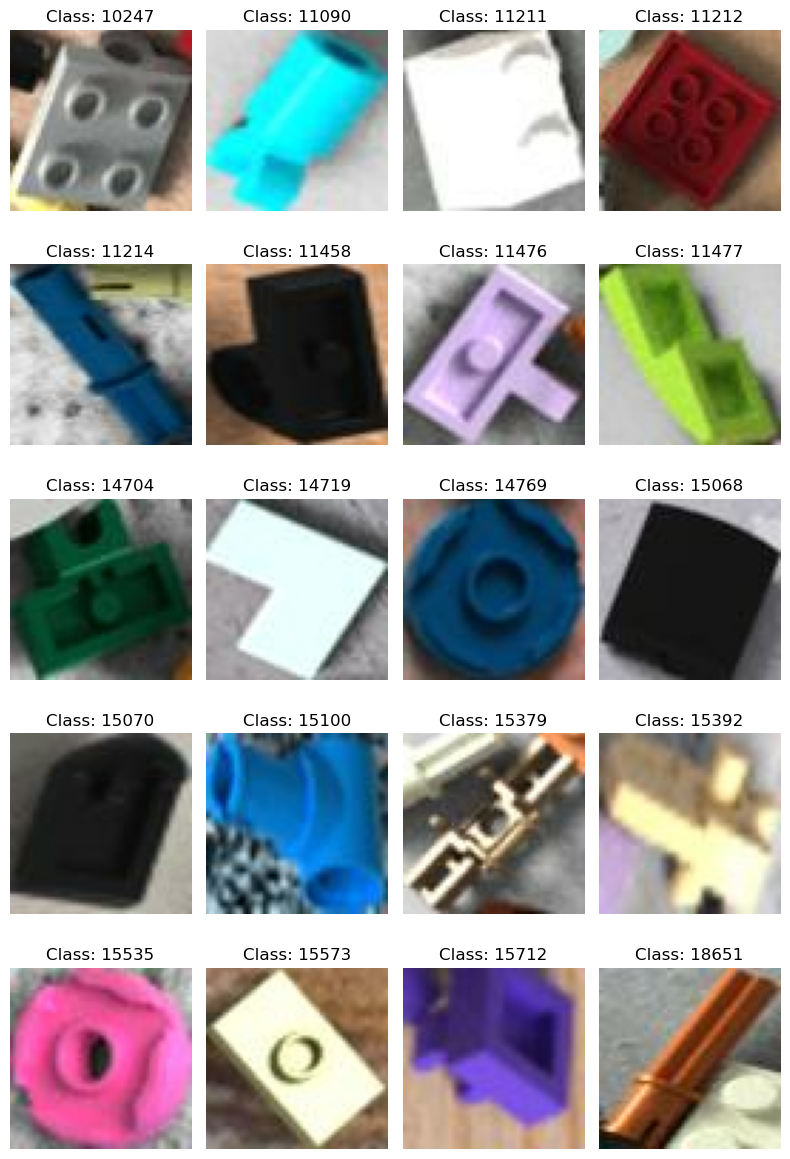

In [112]:
plot_class_examples(X_train,y_train)

In [113]:
# One-Hot Encoding
# Converting strings to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_val_encoded = label_encoder.transform(y_train_val)
y_test_encoded = label_encoder.transform(y_test)

# Converting integers to one-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
y_train_cat = onehot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_train_val_cat = onehot_encoder.transform(y_train_val_encoded.reshape(-1, 1))
y_test_cat = onehot_encoder.transform(y_test_encoded.reshape(-1, 1))

# Check the dimensions
print("Dimensions of y_train_cat:", y_train_cat.shape)
print("Dimensions of y_train_val_cat:", y_train_val_cat.shape)
print("Dimensions of y_test_cat:", y_test_cat.shape)

Dimensions of y_train_cat: (51200, 20)
Dimensions of y_train_val_cat: (12800, 20)
Dimensions of y_test_cat: (16000, 20)


In [114]:
# Optionally: save the class mapping
class_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
print("Class mapping:", class_mapping)

Class mapping: {0: '10247', 1: '11090', 2: '11211', 3: '11212', 4: '11214', 5: '11458', 6: '11476', 7: '11477', 8: '14704', 9: '14719', 10: '14769', 11: '15068', 12: '15070', 13: '15100', 14: '15379', 15: '15392', 16: '15535', 17: '15573', 18: '15712', 19: '18651'}


In [115]:
# Convert numpy to tensorflow tensors
X_train = convert_to_tensors(X_train)
X_train_val = convert_to_tensors(X_train_val)
X_test = convert_to_tensors(X_test)

y_train_cat = convert_to_tensors(y_train_cat)
y_train_val_cat = convert_to_tensors(y_train_val_cat)
y_test_cat = convert_to_tensors(y_test_cat)

print(f'X_train type: {type(X_train)}')

X_train type: <class 'tensorflow.python.framework.ops.EagerTensor'>


# Create CNN model

In [116]:
def create_keras_cnn_model(img_height, img_width, channels,
                           conv_layers, conv_activations, conv_dropout_rates, batch_norm, conv_pooling,
                           layers, activations, dropout_rates,
                           output_dim,
                           optimizer, metrics, loss):
    """
    Creates a convolutional neural network (CNN) model using Keras.

    This function constructs a CNN model with the specified architecture, including convolutional layers,
    activation functions, dropout rates, and dense layers. It compiles the model with the given optimizer,
    loss function, and metrics.

    Args:
        img_height (int): The height of the input images.
        img_width (int): The width of the input images.
        channels (int): The number of channels in the input images (e.g., 1 for grayscale, 3 for RGB).
        conv_layers (list of int): A list specifying the number of filters for each convolutional layer.
        conv_activations (list of str): A list of activation functions for the convolutional layers.
        conv_dropout_rates (list of float): A list of dropout rates for the convolutional layers.
        batch_norm (bool): Flag indicating whether to apply batch normalization after convolutional layers.
        conv_pooling (list of int): A list indicating which convolutional layers should include max pooling.
        layers (list of int): A list specifying the number of units for each dense hidden layer.
        activations (list of str): A list of activation functions for the dense hidden layers.
        dropout_rates (list of float): A list of dropout rates for the dense hidden layers.
        output_dim (int): The number of output units (classes) for the final layer.
        optimizer (str or tf.keras.optimizers.Optimizer): The optimizer to use for compiling the model.
        metrics (list of str or tf.keras.metrics.Metric): A list of metrics to evaluate model performance.
        loss (str or tf.keras.losses.Loss): The loss function to use for compiling the model.

    Returns:
        tf.keras.Model: The compiled Keras model.
    
    Notes:
        - The function uses a truncated normal initializer for the kernel weights.
        - It builds the model in a sequential manner, starting from the input layer through to the output layer.
        - All layers except the output layer are designed to support dropout for regularization.
    """
    # Kernel initializer
    init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=25)

    # Input Layer
    inputs = tf.keras.Input(shape=(img_height, img_width, channels))

    # Conv2D layers
    x = inputs
    for i, (conv_layer, conv_activation, conv_dropout_rate, pooling) in enumerate(zip(conv_layers, conv_activations, conv_dropout_rates, conv_pooling)):
        print(f'Adding conv_layer {conv_layer}, with activation function {conv_activation} and with dropout rate {conv_dropout_rate}')
        x = tf.keras.layers.Conv2D(conv_layer,
                                   (3, 3),
                                   activation=conv_activation,
                                   kernel_initializer=init,
                                   padding='same')(x)
        if batch_norm:
            x = tf.keras.layers.BatchNormalization()(x)
        if pooling == 1:
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
        if conv_dropout_rate > 0:
            x = tf.keras.layers.Dropout(conv_dropout_rate)(x)

    x = tf.keras.layers.Flatten()(x)

    # Hidden layers
    for units, activation, dropout_rate in zip(layers, activations, dropout_rates):
        print(f'Adding layer {units}, with activation function {activation} and with dropout rate {dropout_rate}')
        x = tf.keras.layers.Dense(int(units), activation=activation, kernel_initializer=init)(x)
        if dropout_rate > 0:
            x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(output_dim, kernel_initializer=init)(x)
    outputs = tf.keras.layers.Softmax()(outputs)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    metric_objects = [getattr(tf.keras.metrics, metric)() if isinstance(metric, str) else metric for metric in metrics]
    model.compile(optimizer=optimizer, loss=loss, metrics=metric_objects)

    # Print the model summary for debugging purposes
    print(model.summary())

    return model


In [117]:
# Checking shapes
print(f'X_train shape: {X_train.shape}, type: {type(X_train)}')
print(f'X_train_val shape: {X_train_val.shape}, type: {type(X_train_val)}')
print(f'X_test shape: {X_test.shape}, type: {type(X_test)}\n')

print(f'y_train_cat shape: {y_train_cat.shape}, type: {type(y_train_cat)}')
print(f'y_train_val_cat shape: {y_train_val_cat.shape}, type: {type(y_train_val_cat)}')
print(f'y_test_cat shape: {y_test_cat.shape}, type: {type(y_test_cat)}')

X_train shape: (51200, 64, 64, 3), type: <class 'tensorflow.python.framework.ops.EagerTensor'>
X_train_val shape: (12800, 64, 64, 3), type: <class 'tensorflow.python.framework.ops.EagerTensor'>
X_test shape: (16000, 64, 64, 3), type: <class 'tensorflow.python.framework.ops.EagerTensor'>

y_train_cat shape: (51200, 20), type: <class 'tensorflow.python.framework.ops.EagerTensor'>
y_train_val_cat shape: (12800, 20), type: <class 'tensorflow.python.framework.ops.EagerTensor'>
y_test_cat shape: (16000, 20), type: <class 'tensorflow.python.framework.ops.EagerTensor'>


---
##### RocketNet

---

The code below was used to create a convolutional neural network in this project. The method of building the model is consistent with the Keras documentation and adheres to "industry standards." The second cell defines the same neural network using the **create_keras_cnn_model** function. This function is applicable for testing models and examining how network parameters affect results in the initial phase of analysis. The function offers some flexibility in creating the network however, it does not provide the same level of freedom as the native Keras API. I leave the decision of choosing the method for building the CNN to the user of this notebook. In the following sections, the Keras API will be used.

In [118]:
### Create the CNN model

# Input layer
inputs = tf.keras.Input(shape=(64, 64, 3), name='input_layer')

# First convolutional block
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv_layer_1')(inputs)
x = tf.keras.layers.BatchNormalization(name='batchnorm_layer_1')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer_1')(x)

# Second convolutional block
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', name='conv_layer_2')(x)
x = tf.keras.layers.BatchNormalization(name='batchnorm_layer_2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer_2')(x)

# Third convolutional block
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name='conv_layer_3')(x)
x = tf.keras.layers.BatchNormalization(name='batchnorm_layer_3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), name='maxpool_layer_3')(x)

# Flatten layer
x = tf.keras.layers.Flatten(name='flatten_layer')(x)

# First dense layer
x = tf.keras.layers.Dense(512, activation='relu', name='dense_layer_1')(x)
x = tf.keras.layers.Dropout(0.5, name='dropout_layer')(x)

# Output layer
outputs = tf.keras.layers.Dense(20, activation='softmax', name='output_layer')(x)

# Create the model
rocket_net = tf.keras.Model(inputs=inputs, outputs=outputs, name='rocket_net')

In [119]:
# # CNN Initialization using create_keras_cnn_model function

# # Convolutional layers
# conv_layers = [32, 64, 128]
# conv_activations = ['relu' for _ in range(len(conv_layers))]
# conv_dropout_rates = [0] * (len(conv_layers) - 1) + [0.5]  # No dropout for the first two layers, 0.5 for the last
# conv_pooling = [1, 1, 1]  # Max pooling after each convolutional layer

# # Dense layers
# output_dim = 20  # Assuming there are 20 classes
# layers = [512]  # Single dense layer with 512 units
# activations = ['relu' for _ in range(len(layers))]
# dropout_rates = [0.5]  # Dropout of 0.5 for the dense layer

# # Optimizer and Metrics
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# metrics = [tf.keras.metrics.CategoricalAccuracy(name="Categorical_Accuracy"),
#             tf.keras.metrics.AUC(name='AUC')]
# loss = tf.keras.losses.CategoricalCrossentropy()

# # Create the model using the helper function
# rocket_net = create_keras_cnn_model(img_height=64,
#                                     img_width=64,
#                                     channels=3,
#                                     batch_norm=True,
#                                     conv_layers=conv_layers,
#                                     conv_activations=conv_activations,
#                                     conv_dropout_rates=conv_dropout_rates,
#                                     conv_pooling=conv_pooling,
#                                     layers=layers,
#                                     activations=activations,
#                                     dropout_rates=dropout_rates,
#                                     output_dim=output_dim,
#                                     optimizer=optimizer,
#                                     metrics=metrics,
#                                     loss=loss)


In [120]:
# Learning rate for the optimizer
learning_rate = 0.001

# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Model compilation
rocket_net.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.CategoricalAccuracy(name="Categorical_Accuracy"),
                    tf.keras.metrics.AUC(name='AUC')])

# If the label_mode='categorical' is set in the image_dataset_from_directory function,
# the labels are automatically encoded as one-hot vectors, so categorical_crossentropy is the appropriate loss function.

# Display the model summary
rocket_net.summary()

Model: "rocket_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_1 (Conv2D)           │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_layer_1               │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_2 (Conv2D)           │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_layer_2               │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_layer_3 (Conv2D)           │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_layer_3               │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_layer_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 20)             │        10,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,464,212 (9.40 MB)

 Trainable params: 2,463,764 (9.40 MB)

 Non-trainable params: 448 (1.75 KB)

In [121]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_AUC',
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Train the CNN Model
history_RN = rocket_net.fit(X_train, y_train_cat,
                    validation_data=(X_train_val, y_train_val_cat),
                    batch_size=100,
                    shuffle=False,
                    epochs=50,                      # to check what is happening during the training. For final model use early_stopping
                    callbacks=[early_stopping]    # Uncomment this line if you want to use early stopping
)

Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - AUC: 0.7354 - Categorical_Accuracy: 0.2291 - loss: 2.8725 - val_AUC: 0.7672 - val_Categorical_Accuracy: 0.2498 - val_loss: 2.9763
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9404 - Categorical_Accuracy: 0.5345 - loss: 1.4071 - val_AUC: 0.9639 - val_Categorical_Accuracy: 0.6767 - val_loss: 1.0399
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9691 - Categorical_Accuracy: 0.6761 - loss: 0.9902 - val_AUC: 0.9828 - val_Categorical_Accuracy: 0.7945 - val_loss: 0.6657
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9799 - Categorical_Accuracy: 0.7545 - loss: 0.7573 - val_AUC: 0.9859 - val_Categorical_Accuracy: 0.8274 - val_loss: 0.5663
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9865 - Categorical_Accuracy: 0.8045 - loss: 0.6048 - val_AUC: 0.9868 - val_Categorical_Accuracy: 0.8449 - val_loss: 0.5234
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.9897 - Categorical_

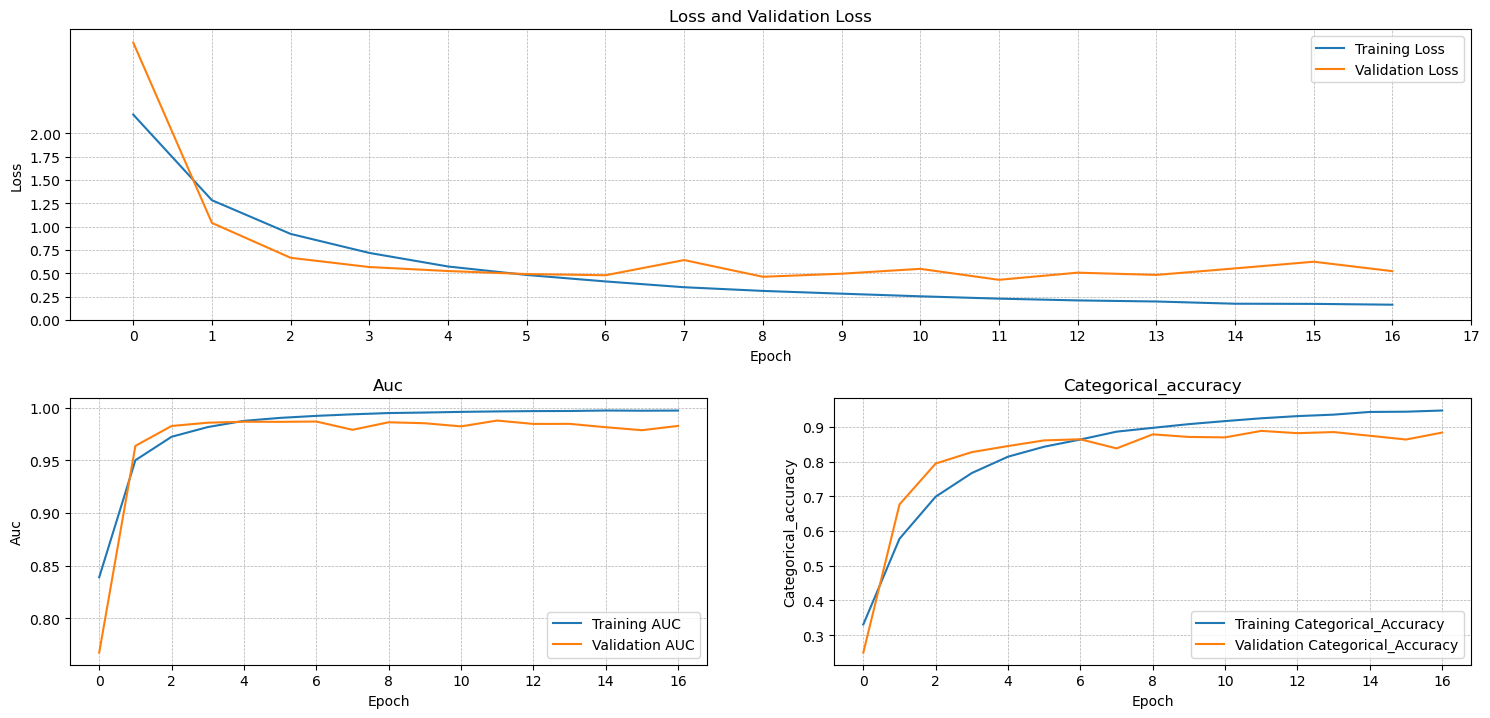

In [122]:
plot_training_history(history_RN,x_ticks_step=1, y_ticks_step=0.25)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


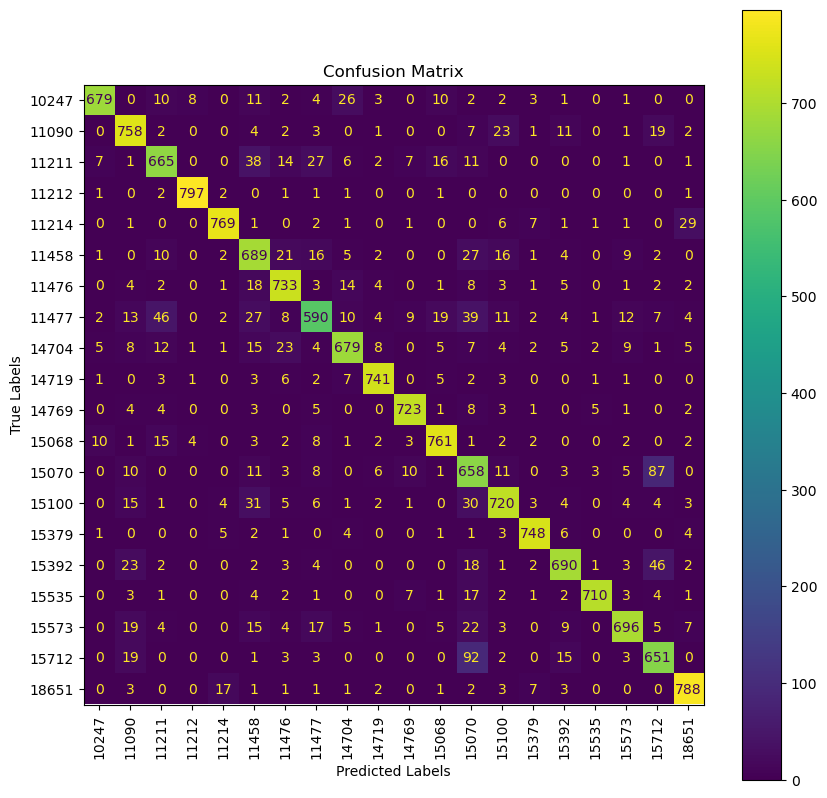

In [123]:
plot_confusion_matrix(rocket_net, X_test, y_test, mapping_dict=class_mapping)

---
##### Alex Net

---


In [124]:
######## AlexNet Model #########
# AlexNet model scaled to 64x64x3 picture. The logic of AlexNet is preserved.

# Kernel initializer
init = tf.keras.initializers.TruncatedNormal(stddev=0.01, seed=25)

# Input Layer
inputs = tf.keras.Input(shape=(64, 64, 3))

# Conv2D layers
x = tf.keras.layers.ZeroPadding2D(padding=2)(inputs)
x = tf.keras.layers.Conv2D(32, (5, 5), strides=1, activation='relu', kernel_initializer=init, name='conv_input_32x5x5')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = tf.keras.layers.ZeroPadding2D(padding=2)(x)
x = tf.keras.layers.Conv2D(64, (5, 5), strides=1, activation='relu', kernel_initializer=init, name='conv_2_64x5x5')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu', kernel_initializer=init, name='conv_3_128x3x3')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation='relu', kernel_initializer=init, name='conv_4_128x3x3')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu', kernel_initializer=init, name='conv_5_64x3x3')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = tf.keras.layers.Flatten()(x)

# Dense Layers
x = tf.keras.layers.Dense(1024, activation='relu', kernel_initializer=init, name='Dense_1_1024')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer=init, name='Dense_2_512')(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Output layer
output_layer = tf.keras.layers.Dense(20, activation='softmax', kernel_initializer=init, name='Output_Layer')(x)

# Create the model
outputs = output_layer
AlexNet = tf.keras.Model(inputs=inputs, outputs=outputs, name="AlexNet")

# Train parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [tf.keras.metrics.CategoricalAccuracy(name="Categorical_Accuracy"),
            tf.keras.metrics.AUC(name='AUC')]
loss = tf.keras.losses.CategoricalCrossentropy()

# Compile the model
AlexNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Print the model summary for debugging purposes
print(AlexNet.summary())


Model: "AlexNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 68, 68, 3)      │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_input_32x5x5 (Conv2D)      │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 36, 36, 32)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_64x5x5 (Conv2D)          │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3_128x3x3 (Conv2D)         │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4_128x3x3 (Conv2D)         │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_5_64x3x3 (Conv2D)          │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1_1024 (Dense)            │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2_512 (Dense)             │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 20)             │        10,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,079,956 (19.38 MB)

 Trainable params: 5,079,636 (19.38 MB)

 Non-trainable params: 320 (1.25 KB)

None


In [125]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_AUC',
    mode='max',
    patience=5,
    restore_best_weights=True
)

# Train AlexNet
history_AlexNet = AlexNet.fit(X_train, y_train_cat,
                    validation_data=(X_train_val, y_train_val_cat),
                    batch_size=100,
                    shuffle=False,
                    epochs=50,                      # to check what is happening during the training. For final model use early_stopping
                    callbacks=[early_stopping]    # Uncomment this line if you want to use early stopping 
                    )

Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - AUC: 0.6719 - Categorical_Accuracy: 0.1490 - loss: 2.6929 - val_AUC: 0.9125 - val_Categorical_Accuracy: 0.4473 - val_loss: 1.7129
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.9137 - Categorical_Accuracy: 0.4460 - loss: 1.6830 - val_AUC: 0.9406 - val_Categorical_Accuracy: 0.5405 - val_loss: 1.4101
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.9438 - Categorical_Accuracy: 0.5474 - loss: 1.3687 - val_AUC: 0.9651 - val_Categorical_Accuracy: 0.6489 - val_loss: 1.0789
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - AUC: 0.9609 - Categorical_Accuracy: 0.6255 - loss: 1.1286 - val_AUC: 0.9142 - val_Categorical_Accuracy: 0.5029 - val_loss: 1.6841
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.9699 - Categorical_Accuracy: 0.6765 - loss: 0.9761 - val_AUC: 0.9815 - val_Categorical_Accuracy: 0.7597 - val_loss: 0.7669
Epoch 6/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.9777 - Categorical

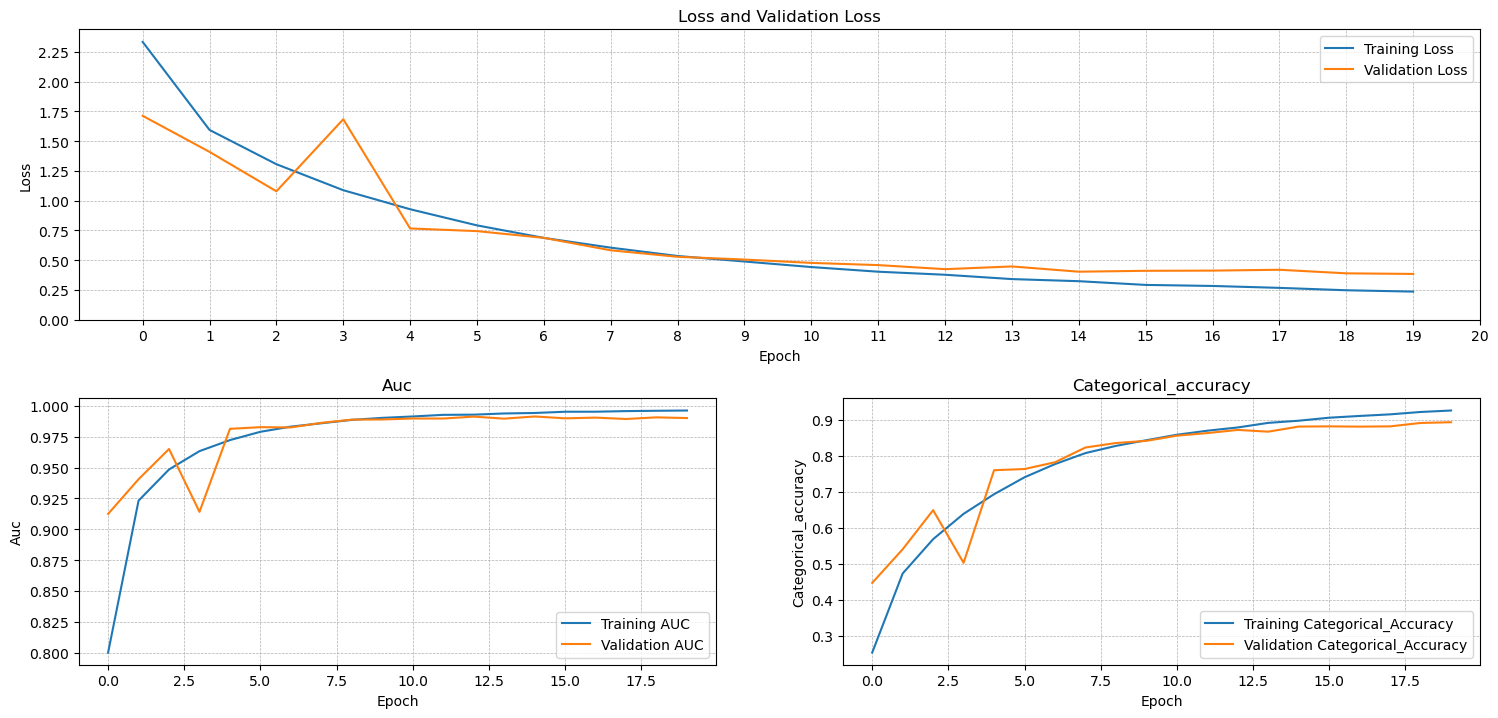

In [126]:
plot_training_history(history_AlexNet,x_ticks_step=1, y_ticks_step=0.25)

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


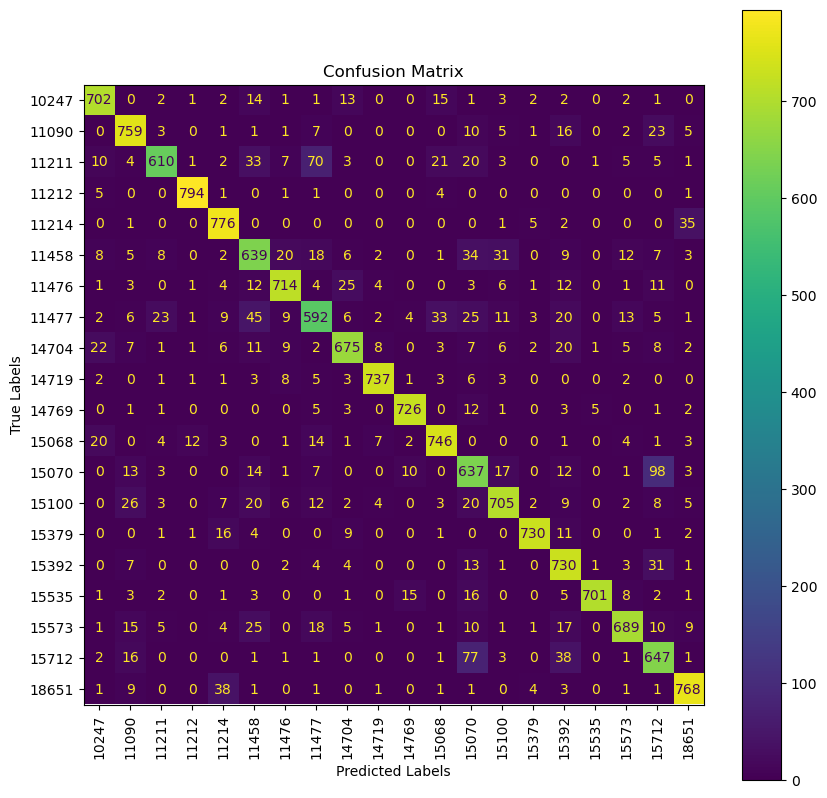

In [127]:
plot_confusion_matrix(AlexNet, X_test, y_test, mapping_dict=class_mapping)

---
Save and Load the models

---

In [128]:
# Save models to h5
# AlexNet.save('AlexNet.h5')
# rocket_net.save('rocket_net.h5')

In [129]:
# Load the models (h5)
# AlexNet = tf.keras.models.load_model('AlexNet.h5')
# rocket_net = tf.keras.models.load_model('rocket_net.h5')

In [130]:
# Save models to pickle (I find it faster to save them as pickle)
save_model(AlexNet,history_AlexNet,'AlexNet.pkl')
save_model(rocket_net,history_RN,'rocket_net.pkl')

In [131]:
# Load models from pickle
load_model('AlexNet.pkl')
load_model('rocket_net.pkl')

(<Functional name=rocket_net, built=True>,
 <keras.src.callbacks.history.History at 0x7fda6c548990>)

### Grad-Cam

**Grad-Cam: Visualizing CNNs for Better Interpretability**

Grad-CAM (Gradient-weighted Class Activation Mapping) is a powerful visualization technique used to interpret the decisions made by Convolutional Neural Networks (CNNs). It allows practitioners and researchers to "see into" a CNN by producing heatmaps that highlight the regions of an input image that are most relevant to a particular prediction. This is particularly important in applications like image classification, where understanding the model's reasoning can lead to better trust, debugging, and refinement of the model.

#### How Grad-CAM Works

**1. Understanding Grad-CAM:**
   
   Grad-CAM leverages the gradients of the output with respect to the final convolutional layer of the CNN to create class-discriminative localization maps. Instead of directly correlating the predictions to the input pixels (as in some other visualization techniques), Grad-CAM focuses on the features learned by the last convolutional layer, which often captures high-level semantic information about the input images.

**2. Steps Involved in Grad-CAM:**

   - **Forward Pass**: Run a forward pass of the image through the CNN to get the model predictions.
   
   - **Backward Pass**: Compute gradients of the predicted class score (the score for a specific class you are interested in) with respect to the feature maps of the last convolutional layer. This gives insight into which features most strongly influence the prediction.
   
   - **Weighting the Feature Maps**: For each feature map from the last convolutional layer, calculate the average of the gradients (global-average pooling). These weights indicate the importance of each feature map for the predicted class.
   
   - **Creating the Heatmap**: Multiply each feature map by its corresponding weight and sum them up. This gives a weighted combination of feature maps that emphasizes the areas of the image that are most relevant to the prediction. 

   - **Applying ReLU**: Apply the ReLU activation function to the obtained weighted sum, ensuring that only the positive contributions (the regions that positively influence the prediction) are retained. This results in a heatmap that shows regions of interest.

   - **Overlaying the Heatmap**: Finally, the heatmap can be resized and overlaid onto the input image. The areas marked in warmer colors (like red or yellow) indicate high relevance for the predicted class, while cooler colors (like blue) show less influential areas.

#### Applications of Grad-CAM

- **Model Interpretation**: By visualizing the areas that the model is focusing on, researchers and practitioners can better understand the decision-making process of CNNs. This is crucial for debugging and ensuring the model is making decisions based on relevant features.

- **Trust and Transparency**: In domains such as healthcare, autonomous driving, and security, understanding what features influence model decisions can increase trust and allow for better risk assessment.

- **Model Improvement**: Identifying areas of a model's focus can inform changes in architecture or training dataset composition to improve model performance.

- **Error Analysis**: Grad-CAM can help in diagnosing why a model is making certain errors, such as misclassifications, by illustrating what parts of the image were considered important for specific predictions.

#### Limitations of Grad-CAM

While Grad-CAM is a useful tool, there are limitations to its effectiveness:
- **Class-specific**: Grad-CAM focuses on a specific class and may not provide a holistic view of all features being used by the model.
- **Sensitivity to Changes**: The visualizations can change significantly with small variations in input images, making interpretation less consistent.
- **Designed for CNNs**: Grad-CAM is primarily tailored for CNNs, which may limit its direct applicability to other types of neural networks.

#### Conclusion

Grad-CAM serves as a crucial bridge in understanding the otherwise opaque decisions made by CNNs. By visualizing the important regions in the input images, it enhances model interpretability, facilitates debugging, and fosters trust, particularly in critical applications where understanding model behavior is essential. As the demand for transparency in AI continues to rise, tools like Grad-CAM will play an increasingly important role in the development and deployment of machine learning models.

In [132]:
# Image Size for Grad-Cam
img_size = (64, 64)

# Remove last layer's softmax
AlexNet.layers[-1].activation = None
rocket_net.layers[-1].activation = None

In [133]:
### Funtions for Grad-Cam ###

def get_img_array(img_array):
    """
    Expand the dimensions of the input image array to create a batch dimension.

    Args:
        img_array (numpy.ndarray): Input image array with shape (height, width, channels).

    Returns:
        numpy.ndarray: Image array reshaped to include a batch dimension, shape (1, height, width, channels).
    """
    array = img_array
    array = np.expand_dims(array, axis=0)  # Add a batch dimension
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Create a Grad-CAM heatmap for a specified convolutional layer.

    Args:
        img_array (numpy.ndarray): Input image array with shape (1, height, width, channels).
        model (keras.Model): Trained Keras model.
        last_conv_layer_name (str): Name of the last convolutional layer to use for Grad-CAM.
        pred_index (int, optional): Index of the predicted class. If None, the index of the highest prediction is used.

    Returns:
        numpy.ndarray: The generated heatmap as a NumPy array.
    """
    _ = model(img_array)  # Perform forward pass to get predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])  # Get index of highest predicted class
        class_channel = preds[:, pred_index]

    # Calculate gradients of the class channel with respect to the last convolutional layer output
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Average the gradients over the spatial dimensions
    last_conv_layer_output = last_conv_layer_output[0]

    # Create a heatmap by multiplying the pooled gradients with the last convolutional layer output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    """
    Code Above:
    Compute the Grad-CAM heatmap by performing a weighted sum of the feature maps
    from the last convolutional layer, using the pooled gradients (importance values) 
    as weights. This results in a heatmap that highlights spatial regions in the 
    input image that are most relevant to the predicted class

    The ellipsis (...) serves as a notation to simplify the slicing notation in multi-dimensional arrays,
    enabling you to focus on the dimensions that are most relevant to your operation without needing
    to cumbersome specify all dimensions. 
    """
    heatmap = tf.squeeze(heatmap)  # Remove single-dimensional entries
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)  # Normalize the heatmap to [0, 1]
    
    return heatmap.numpy()  # Return heatmap as a NumPy array

def blend_with_white_mask(image1, image2, alpha, threshold=250):
    """
    Blend two images together using a white mask.

    Args:
        image1 (PIL.Image or numpy.ndarray): The first image (background).
        image2 (PIL.Image or numpy.ndarray): The second image (foreground, typically the heatmap).
        alpha (float): Weight for blending the images (0 to 1).
        threshold (int): Pixel value threshold to consider pixels as white.

    Returns:
        numpy.ndarray: The blended image as a NumPy array.
    """
    # Convert images to numpy arrays
    arr1 = np.array(image1)
    arr2 = np.array(image2)
    
    # Create a mask for white pixels in the second image
    white_mask = np.all(arr2 >= threshold, axis=-1)
    
    # Perform blending
    blended = (1 - alpha) * arr1 + alpha * arr2
    
    # Apply the mask to retain original pixels where the second image is white
    result = np.where(white_mask[..., None], arr1, blended)
    
    # Return as unsigned 8-bit integers
    return result.astype('uint8')

def save_and_display_gradcam(img_array, heatmap, cmap='jet', alpha=0.1, threshold=250, whites=0, img_size=(224, 224)):
    """
    Save and display the Grad-CAM results, including the heatmap and blended image.

    Args:
        img_array (tf.Tensor): Tensor containing the input image.
        heatmap (numpy.ndarray): The generated heatmap from Grad-CAM.
        cmap (str): The colormap used for the heatmap visualization.
        alpha (float): The blending factor for the heatmap.
        threshold (int): Threshold for the white mask blending.
        whites (int): Number of white pixels to retain (if applicable).
        img_size (tuple): Desired size of the output image.

    Returns:
        tuple: Contains the jet heatmap and the superimposed image.
    """
    # Convert tf.tensor to numpy array
    img = tf.keras.backend.get_value(img_array)
    
    # Normalize pixel values to the range [0, 255]
    img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255
    img = img.astype(np.uint8)
    
    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps[cmap]
    jet_colors = jet(np.arange(256))[:, :3]  # Get RGB values from colormap

    # This handles cases where we want to turn the first 'whites' pixels to white
    if whites >= 0:
        jet_colors[0:whites + 1] = np.array([1, 1, 1])
    
    # Map the heatmap values to the jet colors
    jet_heatmap = jet_colors[heatmap]
   
    # Resize jet_heatmap to match input image dimensions
    jet_heatmap = tf.image.resize(jet_heatmap, (img.shape[0], img.shape[1])).numpy()

    # Convert the numpy arrays back to PIL Image objects
    img = Image_PIL.fromarray(img)
    jet_heatmap = Image_PIL.fromarray((jet_heatmap * 255).astype(np.uint8))
    
    # Blend the heatmap with the original image using a white mask
    superimposed_img = blend_with_white_mask(img, jet_heatmap, alpha, threshold)
    
    return jet_heatmap, superimposed_img

def gradcam_all_conv_layers(img_no, img, model, img_size, cmap='jet', alpha=0.2, threshold=250, whites=0, figure_size=(10, 15)):
    """
    Generate Grad-CAM heatmaps for all convolutional layers in the given model.

    Args:
        img_no (int): Index of the image being processed.
        img (numpy.ndarray): Original input image to be analyzed.
        model (keras.Model): The CNN model used for predictions.
        img_size (tuple): Size of the input image (height, width).
        cmap (str): Colormap to use for the heatmap.
        alpha (float): Blending factor for the heatmap overlay.
        threshold (int): Threshold for white pixel masking.
        whites (int): Number of white pixels in the heatmap.
        figure_size (tuple): Size of the figure containing the plots.

    Returns:
        None: Displays the heatmaps and saves the figure to disk.
    """
    array = img / 255  # Normalize the image array
    img_array = get_img_array(img)  # Get image array with batch dimension
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]  # Identify convolutional layers

    fig, axes = plt.subplots(len(conv_layers), 4, figsize=figure_size)  # Create subplots for each layer
    for i, layer in enumerate(reversed(conv_layers)):  # Iterate over convolutional layers in reverse order
        layer_name = layer.name
        heatmap = make_gradcam_heatmap(img_array, model, layer_name)  # Generate the heatmap
        jet_heatmap, superimposed_img = save_and_display_gradcam(array, heatmap, cmap, alpha, threshold, whites, img_size)  # Save and display

        # Display heatmap without the original image
        axes[i, 0].matshow(heatmap, cmap=cmap)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Heatmap at Layer {len(conv_layers) - i}: {layer_name}")
        
        # Show jet heatmap
        axes[i, 1].imshow(jet_heatmap)
        axes[i, 1].axis('off')
        
        # Show the original image
        axes[i, 2].imshow(array * 255)
        axes[i, 2].axis('off')

        # Show heatmap superimposed on the original image
        axes[i, 3].imshow(superimposed_img)
        axes[i, 3].axis('off')

    # Set titles for the figure
    axes[0, 1].set_title(f"Resized Heatmap")
    axes[0, 2].set_title(f"Original Image")
    axes[0, 3].set_title(f"Blended Image")
    fig.suptitle(f'Model: {model.name} ', fontsize=20)
    plt.tight_layout()
    plt.show()
    
    path = f'Model_{model.name}_image_{img_no}.png'  # Create path for saving the figure
    fig.savefig(path)  # Save the figure to the specified path
    plt.close(fig)  # Close the figure to free memory
    
def find_image_for_label(X_test, y_test, desired_label):
    """
    Function that returns the first image from X_test that has the corresponding
    label in y_test equal to the desired_label.

    Args:
        X_test (tf.Tensor): Tensor containing test images.
        y_test (tf.Tensor): Tensor containing test labels.
        desired_label (int): The label value to search for.

    Returns:
        tf.Tensor or None: The first matching image tensor, or None if not found.
    """
    for i, label in enumerate(y_test):
        if label == desired_label:
            return X_test[i]  # Return the first matching image tensor
    return None  # Return None if no image matches the desired label


The code below will execute the Grad-CAM. The loop is designed to create multiple Grad-CAM visualizations to compare the models with respect to the same image. Adjust the variables to obtain the desired number of images.

In [134]:
# List of models to evaluate
models_list = [rocket_net, AlexNet]

# Number of images to evaluate
start_img = 20
end_img = 21

model: rocket_net, image_number: 20
y_pred = 11477, y_true = 11211
Prediction is false


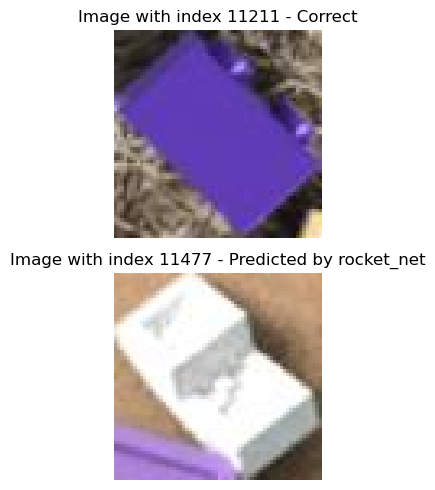

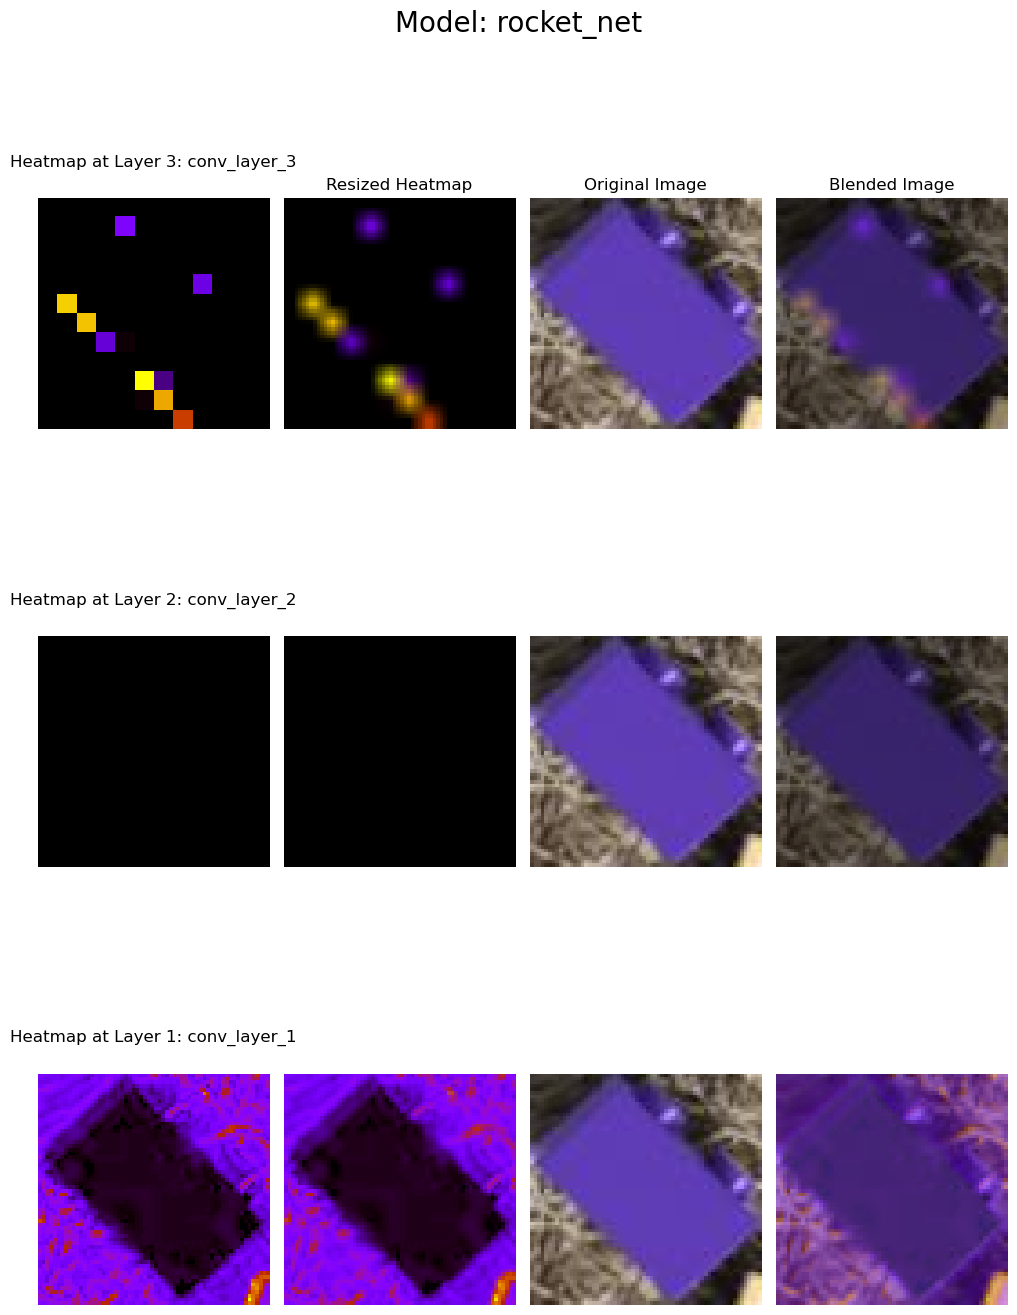

model: AlexNet, image_number: 20
y_pred = 11211, y_true = 11211
Prediction is correct


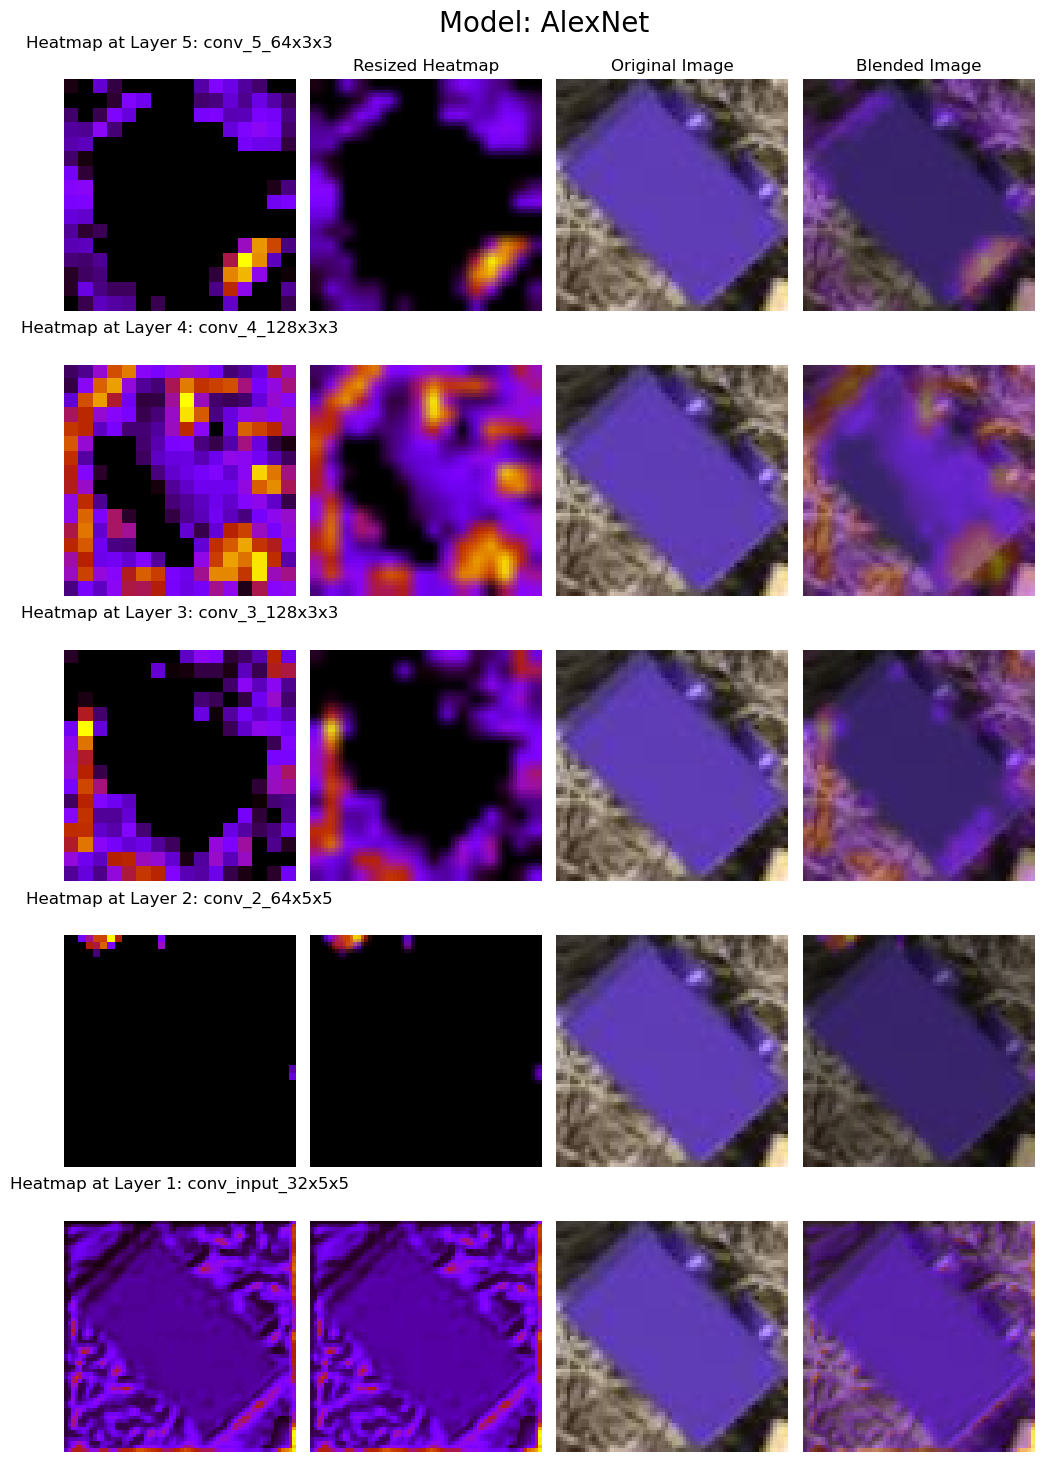

In [138]:

# Iterate over a specified range of images
for img_no in range(start_img, end_img):
    # Loop through each model in the models list
    for model in models_list:
        # Predict the class for the given image and take the index of the highest probability class
        y_pred = np.argmax(model.predict(tf.expand_dims(X_test[img_no], axis=0), verbose=0))
        
        # Map the predicted class index to its corresponding label
        y_pred = class_mapping[y_pred]
        
        # Get the true label for the current image
        y_true = y_test[img_no]

        # Print model name, image number, predicted label, and true label
        print(f'model: {model.name}, image_number: {img_no}')
        print(f'y_pred = {y_pred}, y_true = {y_true}')

        # Check if the prediction is correct and print the result
        if y_pred == y_true:
            print('Prediction is correct')
        else:
            print('Prediction is false')

            # If the prediction is incorrect, visualize the true and predicted images
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))

            # Show the original image that was predicted
            ax1.imshow(X_test[img_no].numpy())
            ax1.axis('off')  # Hide axes for better visualization
            ax1.set_title(f'Image with index {y_true} - Correct')  # Title indicating the true label

            # Find an image that matches the true label for reference
            found_image = find_image_for_label(X_test, y_test, y_pred)
            ax2.imshow(found_image.numpy())  # Display the found image
            ax2.axis('off')  # Hide axes for better visualization
            ax2.set_title(f'Image with index {y_pred} - Predicted by {model.name}')  # Title indicating the predicted label

            # Adjust layout and show the figure
            plt.tight_layout()
            plt.show()
            plt.close()  # Close the figure to free up memory

        # Generate and display Grad-CAM visualizations for all convolutional layers
        gradcam_all_conv_layers(img=X_test[img_no],
                                img_size=(64, 64),  # Define the input image size
                                model=model,  # The model being evaluated
                                cmap='gnuplot',  # Colormap used for visualization
                                alpha=0.4,  # Blending factor for visualizing the heatmap
                                whites=-1,  # Optionally set the number of white pixels to retain
                                threshold=256,  # Threshold for the white mask when blending
                                img_no=img_no  # Current image number for context in the output
                                )
